# Inference of parameters (SEAIRQ model)
In this notebook, we consider the SEAIRQ model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, and quarantined. We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)

when given full data of all the classes from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 1./5           # rate Is -> Q, five days for symptomatic people to be tested and quarantined 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([100, 100])
A0  = np.array([10, 10])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAIRQ_traj.npy', data_array)

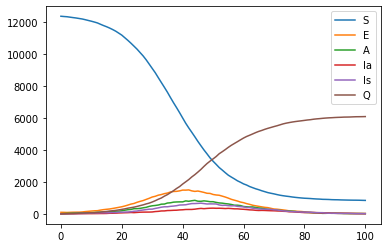

In [3]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')
plt.legend()
plt.show()

## 2) Inference
We take the first $30$ data points of the trajectory and use it to infer the parameters of the model.

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 30 
Nf_inference = Tf_inference + 1 

x = np.load('SEAIRQ_traj.npy').astype('float')
x = x[:Nf_inference]/N
steps = 4 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2797.4867760130755
0.15836715698242188


In [5]:
eps = 1e-4 

alpha_g = 0.3         
alpha_std = 0.1
alpha_b = (eps, 0.5)

beta_g  = 0.05        
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.25
gE_std = 0.1
gE_b = (eps, 0.5)

gA_g    = 0.3 
gA_std = 0.1
gA_b = (eps, 0.5) 
   

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
                   
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]) 
                   
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std]) 
            
start_time = time.time()
params = estimator.inference(guess, stds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds=bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=3548581977, Wed May 27 13:48:22 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.605671643314438e+02 1.0e+00 9.07e-01  4e-02  9e-02 0:01.0
    2     32 -2.553138075522573e+03 1.3e+00 8.84e-01  4e-02  9e-02 0:01.9
    3     48 -1.604685500360598e+03 1.4e+00 9.40e-01  4e-02  1e-01 0:02.7
    7    112 -2.586638343441500e+03 1.8e+00 7.80e-01  3e-02  8e-02 0:06.3
   12    192 -2.334901795672405e+03 2.5e+00 6.45e-01  3e-02  8e-02 0:10.3
   18    288 -2.043313304628280e+03 3.6e+00 7.61e-01  4e-02  9e-02 0:15.4
Optimal value (global minimisation):  -2586.6383434415
Starting local minimisation...
Optimal value (local minimisation):  -2770.579760606926
19.62944984436035


In [6]:
# save the parameters 
np.save('SEAIRQ_param.npy', params)

In [7]:
print('True parameters')
print(parameters)

params = np.load('SEAIRQ_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gE': 0.2, 'gA': 0.3333333333333333, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8, 'tS': 0.0, 'tE': 0.01, 'tA': 0.01, 'tIa': 0.01, 'tIs': 0.2, 'gAA': 0.3333333333333333, 'gAS': 0.3333333333333333}

 Best estimates
{'alpha': 0.22059424875631103, 'beta': 0.02029756631555327, 'gIa': 0.1519942334797863, 'gIs': 0.15791688826793793, 'gE': 0.1872306842576969, 'gA': 0.28131960011545787, 'fsa': array([0.8, 0.8]), 'tS': 0, 'tE': array([0.01, 0.01]), 'tA': array([0.01, 0.01]), 'tIa': array([0.01, 0.01]), 'tIs': array([0.2, 0.2])}


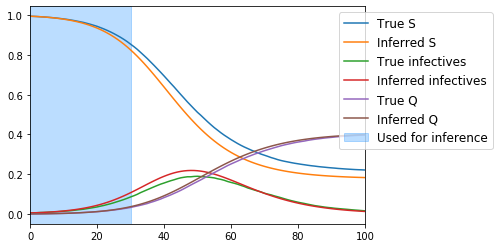

In [8]:
x0 = x[0]
det_model = estimator.make_det_model(best_estimates)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAIRQ_traj.npy').astype('float')/N

plt.plot(np.sum(x[:,0:M], axis=1), label='True S')
plt.plot(np.sum(x_det[:,0:M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:,M:5*M], axis=1), label='True infectives')
plt.plot(np.sum(x_det[:, M:5*M], axis=1), label='Inferred infectives')
plt.plot(np.sum(x[:, 5*M:], axis=1), label='True Q')
plt.plot(np.sum(x_det[:, 5*M:], axis=1), label='Inferred Q')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()